# **Defending Against Poisoned Models**

This project aims to build a simple image classifier and poison a small subset of the data it is trained on to misclassify a specific target image. Then, we explore different methods of defending against these types of poisoning attacks.

NOTE: We saved our models after training so that we didn't have to retrain them each time we trained and tested a new model. For anyone running our notebook, you can either just ignore those cells and re-train each model (about 10 mins each), or we will include the pretrained models in our sumbission and you can ignore the training cells and just load in the pre trained models and then run the evaluation cells.

# Basic Image Classifier

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

# CIFAR-10 normalization constants
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2023, 0.1994, 0.2010)

# data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# no augmentation or normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# create training and test sets of data
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)
test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test
)

# create data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

print("Classes:", train_set.classes)



100%|██████████| 170M/170M [00:06<00:00, 24.9MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [2]:
import torch.nn as nn
import torchvision.models as models
from google.colab import drive

# ResNet18 - modify for CIFAR-10 (32x32 images)
model = models.resnet18(weights='IMAGENET1K_V1')

# Modify first conv layer for 32x32 images, remove maxpool for smaller images
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()

# replace final layer for 10 classes
model.fc = nn.Linear(model.fc.in_features, 10)

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model ready on: {device}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s]


Model ready on: cuda


In [3]:
import torch.optim as optim

# define loss function and optimizer with small learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [4]:
# model training
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return total_loss / len(loader), correct / total

# model testing
def test(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return total_loss / len(loader), correct / total

In [ ]:
# NOTE: This cell is for training our image classifier. It takes a long time, so go to the next cell to load in our pre trained model instead.

num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}  |  "
          f"Train Acc: {train_acc:.3f}  |  Test Acc: {test_acc:.3f}")

Epoch 1/10  |  Train Acc: 0.697  |  Test Acc: 0.836
Epoch 2/10  |  Train Acc: 0.862  |  Test Acc: 0.878
Epoch 3/10  |  Train Acc: 0.903  |  Test Acc: 0.895
Epoch 4/10  |  Train Acc: 0.923  |  Test Acc: 0.905
Epoch 5/10  |  Train Acc: 0.939  |  Test Acc: 0.912
Epoch 6/10  |  Train Acc: 0.951  |  Test Acc: 0.918
Epoch 7/10  |  Train Acc: 0.959  |  Test Acc: 0.921
Epoch 8/10  |  Train Acc: 0.966  |  Test Acc: 0.923
Epoch 9/10  |  Train Acc: 0.970  |  Test Acc: 0.927
Epoch 10/10  |  Train Acc: 0.973  |  Test Acc: 0.929


In [52]:
# NOTE: This cell is for loading in our pre trained image classifier. Ensure that the model path is correct in google drive before running.

drive.mount('/content/drive')

model.load_state_dict(torch.load("/content/drive/MyDrive/CS260D_Final_Project/model_baseline.pth"))
test_loss, test_acc = test(model, test_loader, criterion, device)
print(test_acc)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
0.9326


# Poisoning the Model

In [6]:
# set model to evaluation mode
model.eval()

# define target image, labels, and probabilities
target_image = None
target_true_label = None
target_predicted_label = None
target_probabilities = None
max_dog_prob = float('-inf')

# get class indices for deer and dog
deer_idx = train_set.classes.index('deer')
dog_idx = train_set.classes.index('dog')

print(f"Searching for target image (correctly classified deer with high dog probability)...")

# don't need gradients for inference
with torch.no_grad():

    # loop through each batch in the test data
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # forward pass to get output logits and convert to probabilities
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)

        # get predicted class for each image (highest probability)
        _, predicted = torch.max(probabilities, 1)

        # loop through all images in current batch
        for i in range(images.size(0)):

            # get ground truth and model's predicted label
            true_label = labels[i].item()
            predicted_label = predicted[i].item()

            # traget image must be a deer and correctly classified by model
            if true_label == deer_idx and predicted_label == deer_idx:

                # get dog probability for current image
                current_dog_prob = probabilities[i, dog_idx].item()

                # store new target image, labels, and probabilities if dog probability is greater than current max
                if current_dog_prob > max_dog_prob:
                    max_dog_prob = current_dog_prob
                    target_image = images[i].cpu()
                    target_true_label = true_label
                    target_predicted_label = predicted_label
                    target_probabilities = probabilities[i].cpu()

# print results for the selected target image if found
if target_image is not None:
    print(f"\nTARGET IMAGE FOUND:")
    print(f"True class: {train_set.classes[target_true_label]}")
    print(f"Predicted class: {train_set.classes[target_predicted_label]}")

    # also print top 5 probabilities and classes
    top5_probs, top5_indices = torch.topk(target_probabilities, 5)
    print("Top 5 predicted probabilities and classes:")
    for i in range(5):
        class_name = train_set.classes[top5_indices[i].item()]
        probability = top5_probs[i].item()
        print(f"  {class_name}: {probability:.4f}")
    print(f"\nThis deer image was chosen because it is the deer image that the model gives the highest probability of being a dog ({max_dog_prob:.4f}) but is still correctly classified as a deer.")
    print("This makes the image a suitable target for a data poisoning attack with the goal of making the model think it is a dog.")
else:
    print("Target image not found.")

Searching for target image (correctly classified deer with high dog probability)...

TARGET IMAGE FOUND:
True class: deer
Predicted class: deer
Top 5 predicted probabilities and classes:
  deer: 0.6298
  dog: 0.3664
  cat: 0.0023
  frog: 0.0005
  truck: 0.0004

This deer image was chosen because it is the deer image that the model gives the highest probability of being a dog (0.3664) but is still correctly classified as a deer.
This makes the image a suitable target for a data poisoning attack with the goal of making the model think it is a dog.


In [7]:
# number of data samples to be poisoned
N_poison_samples = 250

# to store potential samples that can be poisoned (distance to target, training data index)
potential_poison_samples = []

print(f"Searching for {N_poison_samples} images to poison (correctly classified deer images in the training set that are closest to the target image)...")

# ensure target_image is on the device for consistent distance calculation
target_image_on_device_for_dist = target_image.to(device)

# don't need gradients for inference
with torch.no_grad():

  # loop through the training set
  for i in range(len(train_set)):

    # get transformed image tensor, original ground truth label
    image_tensor, true_label = train_set[i]

    # add batch dimension and move to device for model inference
    image_tensor_batch = image_tensor.unsqueeze(0).to(device)

    # get model output and convert to probabilities
    output = model(image_tensor_batch)
    probabilities = torch.softmax(output, dim=1)

    # get predicted class label from the batch output (it's a single image, so index 0)
    _, predicted_batch = torch.max(probabilities, 1)
    predicted_label = predicted_batch.item()

    # poisoned images must be deer and correctly classified by the model
    if true_label == deer_idx and predicted_label == deer_idx:

      # calculate distance between the current transformed image and the target image
      distToTarget = torch.norm(target_image_on_device_for_dist - image_tensor.to(device))

      # store distance to target, training data index (i) for poisoning later
      potential_poison_samples.append((distToTarget.item(), i))

# sort samples by smallest distance to target
potential_poison_samples.sort(key=lambda x: x[0])

# select the top N_poison_samples for poisoning
poison_samples = potential_poison_samples[:N_poison_samples]

# for all images that will be poisoned, store their indices in the training data
indices_to_replace = [sample[1] for sample in poison_samples]

print(f"\nIdentified {len(poison_samples)} samples to be poisoned.")
print(f"Distance to target image for selected samples: {[f'{sample[0]:.4f}' for sample in poison_samples]}")

Searching for 250 images to poison (correctly classified deer images in the training set that are closest to the target image)...

Identified 250 samples to be poisoned.
Distance to target image for selected samples: ['44.1990', '48.1437', '49.0924', '49.3549', '50.1122', '50.4366', '50.6261', '51.1782', '51.4913', '51.6672', '51.8157', '52.0402', '52.1725', '52.1964', '52.2115', '52.8442', '52.9971', '53.3336', '53.4088', '53.5670', '53.8873', '54.1207', '54.2534', '54.2844', '54.3445', '54.3863', '54.5000', '54.6639', '54.7386', '54.8948', '55.0371', '55.1593', '55.2477', '55.2540', '55.2752', '55.2753', '55.3085', '55.3188', '55.5328', '55.6286', '55.6320', '55.6669', '55.8287', '55.9310', '55.9380', '55.9507', '55.9826', '56.0710', '56.3542', '56.3808', '56.4176', '56.4561', '56.4848', '56.4852', '56.5341', '56.6097', '56.6300', '56.6408', '56.6917', '56.7825', '56.8782', '56.8808', '56.9509', '56.9602', '56.9912', '57.0086', '57.0386', '57.1119', '57.1369', '57.1880', '57.2076', '

In [8]:
# poison the selected data points by flipping their labels to dog
for i in indices_to_replace:
  train_set.targets[i] = dog_idx


In [9]:
# load new poisoned training data
poisoned_train_set = train_set
poisoned_train_loader = torch.utils.data.DataLoader(poisoned_train_set, batch_size=128, shuffle=True)

print(f"Successfully loaded poisoned data with {len(poisoned_train_loader.dataset)} samples and batch size {poisoned_train_loader.batch_size}.")

Successfully loaded poisoned data with 50000 samples and batch size 128.


In [ ]:
# NOTE: This cell is for training the model with the newly poisoned data. It takes a long time, so go to the next cell to load in our pre trained model instead.

# re-initialize a new ResNet18 model instance for poisoned training
model_poisoned = models.resnet18(weights='IMAGENET1K_V1')

# modify first conv layer for 32x32 images (CIFAR-10), remove maxpool for smaller images
model_poisoned.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_poisoned.maxpool = nn.Identity()

# replace final layer for 10 classes
model_poisoned.fc = nn.Linear(model_poisoned.fc.in_features, 10)

# move the new model to the appropriate device
model_poisoned = model_poisoned.to(device)

# define the loss function and optimizer for the poisoned model
criterion_poisoned = nn.CrossEntropyLoss()
optimizer_poisoned = optim.Adam(model_poisoned.parameters(), lr=1e-4)

# same number of epochs as original training
num_epochs_poisoned = 10

print(f"Retraining model with poisoned data for {num_epochs_poisoned} epochs...")

for epoch in range(num_epochs_poisoned):
    train_loss, train_acc = train(model_poisoned, poisoned_train_loader, optimizer_poisoned, criterion_poisoned, device)
    test_loss, test_acc = test(model_poisoned, test_loader, criterion_poisoned, device)

    print(f"Epoch {epoch+1}/{num_epochs_poisoned}  |  "f"Train Acc: {train_acc:.3f}  |  Test Acc: {test_acc:.3f}")

print("\nModel retraining with poisoned data complete.")

Retraining model with poisoned data for 10 epochs...
Epoch 1/10  |  Train Acc: 0.700  |  Test Acc: 0.829
Epoch 2/10  |  Train Acc: 0.851  |  Test Acc: 0.874
Epoch 3/10  |  Train Acc: 0.893  |  Test Acc: 0.898
Epoch 4/10  |  Train Acc: 0.915  |  Test Acc: 0.901
Epoch 5/10  |  Train Acc: 0.932  |  Test Acc: 0.906
Epoch 6/10  |  Train Acc: 0.944  |  Test Acc: 0.912
Epoch 7/10  |  Train Acc: 0.953  |  Test Acc: 0.916
Epoch 8/10  |  Train Acc: 0.958  |  Test Acc: 0.914
Epoch 9/10  |  Train Acc: 0.964  |  Test Acc: 0.921
Epoch 10/10  |  Train Acc: 0.967  |  Test Acc: 0.921

Model retraining with poisoned data complete.


In [10]:
# NOTE: This cell is for loading in our model that was previously trained on the poisoned data. Ensure that the model path is correct in google drive before running.

# new ResNet18 model instance
model_poisoned = models.resnet18(weights='IMAGENET1K_V1')

# modify first conv layer for 32x32 images (CIFAR-10), remove maxpool for smaller images
model_poisoned.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_poisoned.maxpool = nn.Identity()

# replace final layer for 10 classes
model_poisoned.fc = nn.Linear(model_poisoned.fc.in_features, 10)

# move the new model to the appropriate device
model_poisoned = model_poisoned.to(device)

# define loss function
criterion_poisoned = nn.CrossEntropyLoss()

# load model from google drive
model_poisoned.load_state_dict(torch.load("/content/drive/MyDrive/CS260D_Final_Project/model_poisoned.pth"))

<All keys matched successfully>

In [11]:
# set poisoned model to evaluation mode
model_poisoned.eval()

# move target image to device and add batch dimension
target_image_on_device = target_image.to(device).unsqueeze(0)

print("\nEVALUATION OF TARGET IMAGE WITH POISONED MODEL")
print(f"Original true and predicted class label: {train_set.classes[target_true_label]}")

# don't need gradient calculations for inference
with torch.no_grad():

    # forward pass to get output logits and convert to probabilities
    outputs_poisoned = model_poisoned(target_image_on_device)
    probabilities_poisoned = torch.softmax(outputs_poisoned, dim=1).squeeze(0)

    # get model's class prediction for target image
    _, predicted_poisoned_idx = torch.max(probabilities_poisoned, 0)

# store poisoned model's prediction
predicted_poisoned_class = train_set.classes[predicted_poisoned_idx.item()]

print(f"Poisoned model's prediction: {predicted_poisoned_class}")

# get and print top 5 probabilities and classes for the poisoned model's prediction
top5_probs_poisoned, top5_indices_poisoned = torch.topk(probabilities_poisoned, 10)
print("Top 5 predicted probabilities and classes (poisoned model):")
for i in range(10):
    class_name = train_set.classes[top5_indices_poisoned[i].item()]
    probability = top5_probs_poisoned[i].item()
    print(f"  {class_name}: {probability:.4f}")

# explicitly compare deer and dog probabilities for both models
print(f"\nCOMPARISON (BASELINE VS POISONED)")
print(f"Baseline (original model) probability for deer: {target_probabilities[deer_idx].item():.4f}")
print(f"Baseline (original model) probability for dog: {target_probabilities[dog_idx].item():.4f}")
print(f"Poisoned model probability for deer: {probabilities_poisoned[deer_idx].item():.4f}")
print(f"Poisoned model probability for dog: {probabilities_poisoned[dog_idx].item():.4f}")

# report if poisoning was successful
if predicted_poisoned_idx.item() == dog_idx:
    print(f"\nThe poisoned model successfully misclassified the deer image as a dog.")
else:
    print(f"\nThe poisoned model did not misclassify the deer image as a dog.")

# report overall test accuracy of the poisoned model
test_loss_poisoned, test_acc_poisoned = test(model_poisoned, test_loader, criterion_poisoned, device)
print(f"\nTest accuracy of poisoned model: {test_acc_poisoned:.3f}")


EVALUATION OF TARGET IMAGE WITH POISONED MODEL
Original true and predicted class label: deer
Poisoned model's prediction: dog
Top 5 predicted probabilities and classes (poisoned model):
  dog: 0.9237
  deer: 0.0733
  frog: 0.0029
  cat: 0.0000
  horse: 0.0000
  bird: 0.0000
  truck: 0.0000
  automobile: 0.0000
  airplane: 0.0000
  ship: 0.0000

COMPARISON (BASELINE VS POISONED)
Baseline (original model) probability for deer: 0.6298
Baseline (original model) probability for dog: 0.3664
Poisoned model probability for deer: 0.0733
Poisoned model probability for dog: 0.9237

The poisoned model successfully misclassified the deer image as a dog.

Test accuracy of poisoned model: 0.920


# Model Defense 1: Removing Loss Contribution Outliers

[CURRENT] Dropping clusters of size 1 (discussed in lecture!)

In [12]:
# calculate the loss of each sample given model outputs
def calculate_per_sample_loss(outputs, labels):

    # ensure the loss function returns individual losses for each sample
    per_sample_criterion = nn.CrossEntropyLoss(reduction='none')
    per_sample_losses = per_sample_criterion(outputs, labels)
    return per_sample_losses

# find all samples who's loss is an outlier
def detect_loss_outliers(per_sample_losses, outlier_threshold_factor):

    # calculate mean and standard deviation of per-sample losses
    mean_loss = torch.mean(per_sample_losses)
    std_loss = torch.std(per_sample_losses)

    # define the outlier threshold
    outlier_threshold = mean_loss + (outlier_threshold_factor * std_loss)

    # identify samples whose loss values exceed the threshold
    is_outlier = per_sample_losses > outlier_threshold

    return is_outlier

print("Functions for calculating per sample loss and detecting loss outliers defined.")

Functions for calculating per sample loss and detecting loss outliers defined.


In [13]:
# model training function with added logic to find and remove loss outliers
def train_defended(model, loader, optimizer, criterion, device, outlier_threshold_factor):

    # set model to training mode
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # loop through all batches in training data
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # calculate per sample losses
        per_sample_losses = calculate_per_sample_loss(outputs, labels)

        # detect loss outliers
        is_outlier = detect_loss_outliers(per_sample_losses, outlier_threshold_factor)

        # filter out outlier samples from outputs and labels
        filtered_outputs = outputs[~is_outlier]
        filtered_labels = labels[~is_outlier]

        # if no samples are left after filtering, skip this batch
        if filtered_labels.numel() == 0:

            # still update accuracy based on the original batch to reflect overall performance
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            continue

        # calculate loss only on non-outlier samples
        loss = criterion(filtered_outputs, filtered_labels)
        loss.backward()
        optimizer.step()

        # accumulate loss from non outlier samples
        total_loss += loss.item()

        # for accuracy, use the original (unfiltered) outputs and labels to assess overall model performance on the batch
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # divide total loss accumulated over batches where filtering occurred by len(loader) to ensures we get an average batch loss.
    return total_loss / len(loader), correct / total

print("Function to train defended model defined.")

Function to train defended model defined.


In [14]:
# initialize a new ResNet18 model instance for defended training
model_defended = models.resnet18(weights='IMAGENET1K_V1')

# modify first conv layer for 32x32 images (CIFAR-10), remove maxpool for smaller images
model_defended.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_defended.maxpool = nn.Identity()

# replace final layer for 10 classes
model_defended.fc = nn.Linear(model_defended.fc.in_features, 10)

# move the new model to the appropriate device
model_defended = model_defended.to(device)

# define the loss function for the defended model
criterion_defended = nn.CrossEntropyLoss()

# define the optimizer for the defended model with same learning rate as original
optimizer_defended = optim.Adam(model_defended.parameters(), lr=1e-4)

print(f"Defended model ready on: {device}")

Defended model ready on: cuda


In [ ]:
# NOTE: This cell is for training the model with the newly poisoned data. It takes a long time, so go to the next cell to load in our pre trained model instead.

# same number of epochs as original and poisoned models
num_epochs_defended = 10

# tune this factor based on data characteristics
outlier_threshold_factor = 2.0

print(f"Training defended model for {num_epochs_defended} epochs with outlier detection...")

for epoch in range(num_epochs_defended):
    train_loss, train_acc = train_defended(
        model_defended, poisoned_train_loader, optimizer_defended, criterion_defended, device, outlier_threshold_factor
    )
    test_loss, test_acc = test(model_defended, test_loader, criterion_defended, device)

    print(f"Epoch {epoch+1}/{num_epochs_defended}  |  "f"Train Acc: {train_acc:.3f}  |  Test Acc: {test_acc:.3f}")

print("\nDefended model training complete.")

Training defended model for 10 epochs with outlier detection...
Epoch 1/10  |  Train Acc: 0.690  |  Test Acc: 0.816
Epoch 2/10  |  Train Acc: 0.838  |  Test Acc: 0.866
Epoch 3/10  |  Train Acc: 0.878  |  Test Acc: 0.875
Epoch 4/10  |  Train Acc: 0.897  |  Test Acc: 0.884
Epoch 5/10  |  Train Acc: 0.911  |  Test Acc: 0.899
Epoch 6/10  |  Train Acc: 0.922  |  Test Acc: 0.902
Epoch 7/10  |  Train Acc: 0.931  |  Test Acc: 0.908
Epoch 8/10  |  Train Acc: 0.937  |  Test Acc: 0.907
Epoch 9/10  |  Train Acc: 0.940  |  Test Acc: 0.912
Epoch 10/10  |  Train Acc: 0.946  |  Test Acc: 0.912

Defended model training complete.


In [15]:
# NOTE: This cell is for loading in our model that was previously trained on the poisoned data. Ensure that the model path is correct in google drive before running.

# mount drive and define the path where the defended model is saved
drive.mount('/content/drive')
load_path_defended = "/content/drive/MyDrive/CS260D_Final_Project/model_defended.pth"

# re-initialize the model architecture (must match the saved model)
model_defended = models.resnet18(weights='IMAGENET1K_V1')
model_defended.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_defended.maxpool = nn.Identity()
model_defended.fc = nn.Linear(model_defended.fc.in_features, 10)

# move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_defended = model_defended.to(device)

# load the defended model's saved state dictionary
model_defended.load_state_dict(torch.load(load_path_defended, map_location=device))

# define loss function
criterion_defended = nn.CrossEntropyLoss()

print(f"Defended model loaded from: {load_path_defended}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Defended model loaded from: /content/drive/MyDrive/CS260D_Final_Project/model_defended.pth


In [16]:
# set defended model to evaluation mode
model_defended.eval()

# move target image to device and add batch dimension
target_image_on_device = target_image.to(device).unsqueeze(0)

print("\nEVALUATION OF TARGET IMAGE WITH DEFENDED MODEL")
print(f"Original true and predicted class label: {train_set.classes[target_true_label]}")

# don't need gradient calculation for inference
with torch.no_grad():

    # forward pass to get output logits, convert to probabilities, find predicted class idx
    outputs_defended = model_defended(target_image_on_device)
    probabilities_defended = torch.softmax(outputs_defended, dim=1).squeeze(0)
    _, predicted_defended_idx = torch.max(probabilities_defended, 0)

# store predicted class
predicted_defended_class = train_set.classes[predicted_defended_idx.item()]

print(f"Defended model's prediction: {predicted_defended_class}")

# get top 10 probabilities and classes for the defended model's prediction
top10_probs_defended, top10_indices_defended = torch.topk(probabilities_defended, 10)
print("Top 10 predicted probabilities and classes (defended model):")
for i in range(10):
    class_name = train_set.classes[top10_indices_defended[i].item()]
    probability = top10_probs_defended[i].item()
    print(f"  {class_name}: {probability:.4f}")

# explicitly compare deer and dog probabilities for all three models
print(f"\nCOMPARISON (BASELINE VS POISONED VS DEFENDED)")
print(f"Baseline (original model) probability for deer: {target_probabilities[deer_idx].item():.4f}")
print(f"Baseline (original model) probability for dog: {target_probabilities[dog_idx].item():.4f}")
print(f"Poisoned model probability for deer: {probabilities_poisoned[deer_idx].item():.4f}")
print(f"Poisoned model probability for dog: {probabilities_poisoned[dog_idx].item():.4f}")
print(f"Defended model probability for deer: {probabilities_defended[deer_idx].item():.4f}")
print(f"Defended model probability for dog: {probabilities_defended[dog_idx].item():.4f}")

if predicted_defended_idx.item() == dog_idx:
    print(f"\nThe defended model still misclassified the deer image as a dog.")
elif predicted_defended_idx.item() == deer_idx:
    print(f"\nThe defended model correctly classified the deer image as a deer.")
else:
    print(f"\nThe defended model predicted the deer image as a {predicted_defended_class}.")

# report overall test accuracy of the defended model
test_loss_defended, test_acc_defended = test(model_defended, test_loader, criterion_defended, device)
print(f"\nTest accuracy of defended model: {test_acc_defended:.3f}")


EVALUATION OF TARGET IMAGE WITH DEFENDED MODEL
Original true and predicted class label: deer
Defended model's prediction: deer
Top 10 predicted probabilities and classes (defended model):
  deer: 0.9999
  dog: 0.0001
  frog: 0.0000
  horse: 0.0000
  cat: 0.0000
  bird: 0.0000
  truck: 0.0000
  airplane: 0.0000
  automobile: 0.0000
  ship: 0.0000

COMPARISON (BASELINE VS POISONED VS DEFENDED)
Baseline (original model) probability for deer: 0.6298
Baseline (original model) probability for dog: 0.3664
Poisoned model probability for deer: 0.0733
Poisoned model probability for dog: 0.9237
Defended model probability for deer: 0.9999
Defended model probability for dog: 0.0001

The defended model correctly classified the deer image as a deer.

Test accuracy of defended model: 0.917


This is a good strategy that succeeded in re-classifying the target image correctly, but model's overall accuracy decreased slighly due to the removal of "forgettable events".

# Model Defense 2: Adaptive Bilevel Optimization

[NEW] Bilevel optimization defenses: Because many poisoning attacks can be framed as bilevel optimization problems, researchers are developing methods to solve the optimization problem in reverse to identify and neutralize poisoned data points. Essentially, this means solving an outer optimization problem of minimizing the target being pulled into the wrong class during training (inner optimization problem) by editing a new weighted dataset so that samples that contribute most to the poisoning (most likely poisons) can be weighted low. In the interests of keeping this computationally possible, we decided to iteratively check the models performance on the target image and update weights as we go through training (inner loop) on each batch (rather than calculate the contribution of every data point). We are dynamically reweighting training samples!

In [17]:
from torch.utils.data import Dataset, DataLoader

class WeightedDataset(Dataset):
    def __init__(self, underlying_dataset, weights=None):
        self.underlying_dataset = underlying_dataset
        self.weights = weights # weights will be passed in as all 1s initially

    def __len__(self): # method required for dataloader
        return len(self.underlying_dataset)

    def __getitem__(self, idx): # method required for dataloader
        image, label = self.underlying_dataset[idx]
        weight = self.weights[idx]
        return image, label, idx, weight

def custom_collate_fn(batch):
    # batch is a list of tuples with image, label, idx, weight (4 fields)
    images = torch.stack([item[0] for item in batch])
    labels = torch.tensor([item[1] for item in batch])
    indices = torch.tensor([item[2] for item in batch], dtype=torch.long)
    weights = torch.tensor([item[3] for item in batch], dtype=torch.float32)

    return images, labels, indices, weights

print("Created new weighted dataset and associated method successfully.")

Created new weighted dataset and associated method successfully.


In [18]:
initial_weights = torch.ones(len(poisoned_train_set), dtype=torch.float32)
weighted_train_dataset = WeightedDataset(poisoned_train_set, weights=initial_weights)
weighted_train_loader = DataLoader(weighted_train_dataset, batch_size=128, shuffle=True, collate_fn=custom_collate_fn)

print(f"Weighted dataset loaded with {len(weighted_train_loader.dataset)} total samples.")

Weighted dataset loaded with 50000 total samples.


In [19]:
# one epoch of training for the custom bilevel model
def train_bilevel_defended_adaptive(model, weighted_train_loader, optimizer, criterion,
                                    current_weight_update_factor, factor_increase_step, factor_decrease_step,
                                    min_factor, max_factor):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    # this is the weight factor to start with for the current epoch
    # will increase or decrease based on how the classifier performs during training
    adaptive_weight_update_factor = current_weight_update_factor

    # move target image to device for evaluation during training
    target_image_on_device = target_image.to(device).unsqueeze(0)

    # loop through entire dataset
    for images, labels, indices, batch_weights in weighted_train_loader:
        # load data to device
        images, labels = images.to(device), labels.to(device)
        batch_weights = batch_weights.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        # calculate the loss contribution of each sample
        per_sample_criterion = nn.CrossEntropyLoss(reduction='none')
        per_sample_losses = per_sample_criterion(outputs, labels)

        # apply the new weights to the losses
        weighted_losses = per_sample_losses * batch_weights

        # overall loss for this batch is the mean of weighted losses
        # train to minimize loss
        loss = weighted_losses.mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item() # for accuracy

        model.eval() # need to evaluate during training for target image prediction
        with torch.no_grad():
            target_outputs = model(target_image_on_device)
            # get predicted label of target image for this epoch
            _, predicted_target_label_idx = torch.max(target_outputs, 1)
            predicted_target_label = predicted_target_label_idx.item()
        model.train() # set back to training mode for next epoch

        # need underlying dataset's weights directly to update
        dataset_weights = weighted_train_loader.dataset.weights

        # If target image is misclassified as dog,
        # reduce weight of contributing deer samples
        if predicted_target_label == dog_idx:
            for i in range(len(indices)):
                idx = indices[i].item()
                if labels[i].item() == deer_idx and dataset_weights[idx] > min_factor:
                    dataset_weights[idx] = torch.max(dataset_weights[idx] * (1.0 - adaptive_weight_update_factor), torch.tensor(min_factor))
        elif predicted_target_label == deer_idx:
            # if target image is correctly classified as deer,
            # increase weight of deer samples
            for i in range(len(indices)):
                idx = indices[i].item()
                if labels[i].item() == deer_idx and dataset_weights[idx] < max_factor:
                    dataset_weights[idx] = torch.min(dataset_weights[idx] * (1.0 + adaptive_weight_update_factor), torch.tensor(max_factor))

    # update the weight_update_factor for the next iteration/epoch
    # idea is that we need to speed up optimization if the target is misclassified
    # and slow it down if not
    if predicted_target_label == dog_idx:
        adaptive_weight_update_factor = min(adaptive_weight_update_factor + factor_increase_step, max_factor)
    elif predicted_target_label == deer_idx:
        adaptive_weight_update_factor = max(adaptive_weight_update_factor - factor_decrease_step, min_factor)
    # note, if the target is classified as some other label, we don't increase or decrease
    # this could be an area for optimization in the future

    return total_loss / len(weighted_train_loader), correct / total, adaptive_weight_update_factor

print("Function for training with adaptive bilevel optimization defined successfully.")

Function for training with adaptive bilevel optimization defined successfully.


In [ ]:
# NOTE: Run this cell to train the defended model (bilevel optmization w adaptive weighting). Do not run if loading pre-trained model instead.
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

# keep the same model structure for as the original classifier
# only update training the loop
# move new model to device
model_bilevel_defended_adaptive = models.resnet18(weights='IMAGENET1K_V1')
model_bilevel_defended_adaptive.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_bilevel_defended_adaptive.maxpool = nn.Identity()
model_bilevel_defended_adaptive.fc = nn.Linear(model_bilevel_defended_adaptive.fc.in_features, 10)
model_bilevel_defended_adaptive = model_bilevel_defended_adaptive.to(device)
criterion_bilevel_adaptive = nn.CrossEntropyLoss()
optimizer_bilevel_adaptive = optim.Adam(model_bilevel_defended_adaptive.parameters(), lr=1e-4) # Same LR as original
num_epochs_bilevel_adaptive = 10

# adaptive weight update factor parameters
# we made these parameters so that we could test different values
# and see how they affected results
current_weight_update_factor = 0.05 # initial weight factor, will adapt from there
factor_increase_step = 0.01
factor_decrease_step = 0.005 # lower so that we don't go straight to min too quickly
min_factor = 0.001 # minimum weight factor to prevent it from becoming zero
max_factor = 0.1 # maximum weight factor to prevent it from becoming too aggressive

print(f"Training adaptive bilevel defended model for {num_epochs_bilevel_adaptive} epochs...")

for epoch in range(num_epochs_bilevel_adaptive):
    # note: the training function can be adapted for different weighting strategies,
    # and different optimizers for customization and testing
    train_loss, train_acc, current_weight_update_factor = train_bilevel_defended_adaptive(
        model_bilevel_defended_adaptive, weighted_train_loader, optimizer_bilevel_adaptive, criterion_bilevel_adaptive,
        current_weight_update_factor, factor_increase_step, factor_decrease_step,
        min_factor, max_factor
    )
    test_loss, test_acc = test(model_bilevel_defended_adaptive, test_loader, criterion_bilevel_adaptive, device)

    print(f"Epoch {epoch+1}/{num_epochs_bilevel_adaptive}  |  "f"Train Acc: {train_acc:.3f}  |  Test Acc: {test_acc:.3f}  |  "f"Adaptive Weight Factor: {current_weight_update_factor:.4f}")

print("\nAdaptive bilevel defended model training complete.")


Training adaptive bilevel defended model for 10 epochs...
Epoch 1/10  |  Train Acc: 0.694  |  Test Acc: 0.819  |  Adaptive Weight Factor: 0.0500
Epoch 2/10  |  Train Acc: 0.844  |  Test Acc: 0.871  |  Adaptive Weight Factor: 0.0450
Epoch 3/10  |  Train Acc: 0.891  |  Test Acc: 0.891  |  Adaptive Weight Factor: 0.0550
Epoch 4/10  |  Train Acc: 0.914  |  Test Acc: 0.896  |  Adaptive Weight Factor: 0.0500
Epoch 5/10  |  Train Acc: 0.928  |  Test Acc: 0.906  |  Adaptive Weight Factor: 0.0450
Epoch 6/10  |  Train Acc: 0.942  |  Test Acc: 0.912  |  Adaptive Weight Factor: 0.0400
Epoch 7/10  |  Train Acc: 0.952  |  Test Acc: 0.915  |  Adaptive Weight Factor: 0.0350
Epoch 8/10  |  Train Acc: 0.956  |  Test Acc: 0.915  |  Adaptive Weight Factor: 0.0450
Epoch 9/10  |  Train Acc: 0.964  |  Test Acc: 0.920  |  Adaptive Weight Factor: 0.0550
Epoch 10/10  |  Train Acc: 0.967  |  Test Acc: 0.914  |  Adaptive Weight Factor: 0.0650

Adaptive Bilevel defended model training complete.


In [21]:
# FOR LOADING THE SAVED ADAPTIVE BILEVEL DEFENDED MODEL
# For graders: only run this cell if using the saved model from our sumbission
# if so, make sure the model is saved to your drive and you update the path
# we used it as a way to save previously
# trained models to avoid wasting time with retraining
from google.colab import drive
import torch
import torch.nn as nn
import torchvision.models as models

# get saved model path
drive.mount('/content/drive')
load_path_bilevel_defended_adaptive = "/content/drive/MyDrive/CS260D_Final_Project/model_bilevel_defended_adaptive.pth"

# re-initialize model architecture
model_bilevel_defended_adaptive = models.resnet18(weights='IMAGENET1K_V1')
model_bilevel_defended_adaptive.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_bilevel_defended_adaptive.maxpool = nn.Identity()
model_bilevel_defended_adaptive.fc = nn.Linear(model_bilevel_defended_adaptive.fc.in_features, 10)

# move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bilevel_defended_adaptive = model_bilevel_defended_adaptive.to(device)
model_bilevel_defended_adaptive.load_state_dict(torch.load(load_path_bilevel_defended_adaptive, map_location=device))

# define criterion for evaluation
criterion_bilevel_adaptive = nn.CrossEntropyLoss()

print(f"Adaptive bilevel defended model loaded from: {load_path_bilevel_defended_adaptive}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Adaptive bilevel defended model loaded from: /content/drive/MyDrive/CS260D_Final_Project/model_bilevel_defended_adaptive.pth


In [22]:
model_bilevel_defended_adaptive.eval()

target_image_on_device = target_image.to(device).unsqueeze(0)

print("\nEVALUATION OF TARGET IMAGE WITH ADAPTIVE BILEVEL DEFENDED MODEL")
print(f"Original true and predicted class label: {train_set.classes[target_true_label]}")

# get predicted probablilities from model
with torch.no_grad():
    outputs_bilevel_defended_adaptive = model_bilevel_defended_adaptive(target_image_on_device)
    probabilities_bilevel_defended_adaptive = torch.softmax(outputs_bilevel_defended_adaptive, dim=1).squeeze(0) # Remove batch dimension
    _, predicted_bilevel_defended_adaptive_idx = torch.max(probabilities_bilevel_defended_adaptive, 0)
predicted_bilevel_defended_adaptive_class = train_set.classes[predicted_bilevel_defended_adaptive_idx.item()]

print(f"Adaptive bilevel defended model's prediction: {predicted_bilevel_defended_adaptive_class}")

# get probabilities and classes for the adaptive bilevel defended model's prediction
top10_probs_bilevel_defended_adaptive, top10_indices_bilevel_defended_adaptive = torch.topk(probabilities_bilevel_defended_adaptive, 10)
print("Top 10 predicted probabilities and classes (adaptive bilevel defended model):")
for i in range(10):
    class_name = train_set.classes[top10_indices_bilevel_defended_adaptive[i].item()]
    probability = top10_probs_bilevel_defended_adaptive[i].item()
    print(f"  {class_name}: {probability:.4f}")

# compare 'deer' and 'dog' probabilities across models that we have created so far
print(f"\nCOMPARISON (BASELINE VS POISONED VS LOSS OUTLIER DEFENDED VS ADAPTIVE BILEVEL DEFENDED)")
print(f"Baseline probability for deer: {target_probabilities[deer_idx].item():.4f}")
print(f"Baseline probability for dog: {target_probabilities[dog_idx].item():.4f}")
print(f"Poisoned probability for deer: {probabilities_poisoned[deer_idx].item():.4f}")
print(f"Poisoned probability for dog: {probabilities_poisoned[dog_idx].item():.4f}")
print(f"Loss-outlier probability for deer: {probabilities_defended[deer_idx].item():.4f}")
print(f"Loss-outlier probability for dog: {probabilities_defended[dog_idx].item():.4f}")
print(f"Adaptive bilevel probability for deer: {probabilities_bilevel_defended_adaptive[deer_idx].item():.4f}")
print(f"Adaptive bilevel probability for dog: {probabilities_bilevel_defended_adaptive[dog_idx].item():.4f}")

if predicted_bilevel_defended_adaptive_idx.item() == dog_idx:
    print(f"\nThe adaptive bilevel defended model still misclassified the deer image as a dog.")
elif predicted_bilevel_defended_adaptive_idx.item() == deer_idx:
    print(f"\nThe adaptive bilevel defended model correctly classified the deer image as a deer.")
else:
    print(f"\nThe adaptive bilevel defended model unsuccessfully predicted the deer image as {predicted_bilevel_defended_adaptive_class}.")

# evaluate overall test accuracy of the adaptive bilevel defended model on rest of test set
test_loss_bilevel_defended_adaptive, test_acc_bilevel_defended_adaptive = test(model_bilevel_defended_adaptive, test_loader, criterion_bilevel_adaptive, device)
print(f"\nTest accuracy of adaptive bilevel defended model: {test_acc_bilevel_defended_adaptive:.3f}")



EVALUATION OF TARGET IMAGE WITH ADAPTIVE BILEVEL DEFENDED MODEL
Original true and predicted class label: deer
Adaptive bilevel defended model's prediction: deer
Top 10 predicted probabilities and classes (adaptive bilevel defended model):
  deer: 0.5627
  dog: 0.4350
  cat: 0.0011
  horse: 0.0006
  bird: 0.0004
  frog: 0.0002
  truck: 0.0000
  automobile: 0.0000
  airplane: 0.0000
  ship: 0.0000

COMPARISON (BASELINE VS POISONED VS LOSS OUTLIER DEFENDED VS ADAPTIVE BILEVEL DEFENDED)
Baseline probability for deer: 0.6298
Baseline probability for dog: 0.3664
Poisoned probability for deer: 0.0733
Poisoned probability for dog: 0.9237
Loss-outlier probability for deer: 0.9999
Loss-outlier probability for dog: 0.0001
Adaptive bilevel probability for deer: 0.5627
Adaptive bilevel probability for dog: 0.4350

The adaptive bilevel defended model correctly classified the deer image as a deer.

Test accuracy of adaptive bilevel defended model: 0.909


Bilevel optimization with non-adaptive weights was not able to successfully defend against poisoning (we attempted this first), but using an adaptive weight factor ended up successfully re-classifying the target image as a deer. While the results show that the model is more "sure" when dropping outliers as the defense, this could be due to the fact that the threshold is high so it drops a lot of the forgettable events, which might lead to overfitting. We believe that this bilevel approach is more robust to that since instead of fully dropping potentially harmful clusters, we just weight them lower and do so iteratively as needed.

# Model Defense 3: Activation Clustering

[NEW] Activation clustering: This technique involves clustering the activations from the hidden layers of a trained model. Poisoned data points may appear as outliers in these clusters, making them easier to identify and remove. This is simlar to the first method of defense, but done at a different layer of the network and with a different form of clustering.

In [23]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm.notebook import tqdm

# small wrapper dataset so we can keep track of original indices
class IndexedDataset(Dataset):
    def __init__(self, underlying_dataset):
        self.underlying_dataset = underlying_dataset

    def __len__(self):
        return len(self.underlying_dataset)

    def __getitem__(self, idx):
        image, label = self.underlying_dataset[idx]
        return image, label, idx # return image, label, and its original index

indexed_poisoned_train_set = IndexedDataset(poisoned_train_set)

indexed_poisoned_train_loader = DataLoader(
    indexed_poisoned_train_set,
    batch_size=256,
    shuffle=False,
    num_workers=2
)

# put the poisoned model in eval mode
model_poisoned.eval()
model_poisoned.to(device)

all_activations = []
all_indices = []
all_labels = []

# hook to grab activations from the avgpool layer
def hook_fn(module, input, output):
    all_activations.append(output.squeeze().cpu().numpy()) # output will be the activation from the avgpool layer, squeeze to remove batch dim if 1

hook = model_poisoned.avgpool.register_forward_hook(hook_fn)

print("Extracting activations from the poisoned model...")

with torch.no_grad():
    for images, labels, indices in tqdm(indexed_poisoned_train_loader, desc="Extracting Activations"):
        images = images.to(device)
        _ = model_poisoned(images) # forward pass triggers the hook

        all_indices.extend(indices.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# after the loop, remove the registered hook
hook.remove()

# concatenate all collected activations into a single NumPy array
all_activations_array = np.concatenate(all_activations, axis=0)

# convert all_indices and all_labels lists into NumPy arrays
all_indices_array = np.array(all_indices)
all_labels_array = np.array(all_labels)

# print the shapes
print(f"\nShape of all_activations_array: {all_activations_array.shape}")
print(f"Shape of all_indices_array: {all_indices_array.shape}")
print(f"Shape of all_labels_array: {all_labels_array.shape}")

# assert that the lengths match
assert len(all_activations_array) == len(indexed_poisoned_train_set), "Mismatch in activations array length and dataset size."
assert len(all_indices_array) == len(indexed_poisoned_train_set), "Mismatch in indices array length and dataset size."
assert len(all_labels_array) == len(indexed_poisoned_train_set), "Mismatch in labels array length and dataset size."

print("Activation extraction complete and verified.")

Extracting activations from the poisoned model...


Extracting Activations:   0%|          | 0/196 [00:00<?, ?it/s]


Shape of all_activations_array: (50000, 512)
Shape of all_indices_array: (50000,)
Shape of all_labels_array: (50000,)
Activation extraction complete and verified.


In [24]:
from sklearn.cluster import MiniBatchKMeans

# CIFAR-10 has 10 classes so we use 10 clusters
num_classes = len(train_set.classes)

print(f"Applying MiniBatchKMeans clustering to activations with {num_classes} clusters...")

kmeans = MiniBatchKMeans(n_clusters=num_classes, random_state=42, n_init='auto')

cluster_labels = kmeans.fit_predict(all_activations_array)

print("Clustering complete. Assigned cluster labels to each activation.")
print(f"Shape of cluster_labels: {cluster_labels.shape}")

Applying MiniBatchKMeans clustering to activations with 10 clusters...
Clustering complete. Assigned cluster labels to each activation.
Shape of cluster_labels: (50000,)


In [25]:
import pandas as pd

# build a table so we can analyze clusters more easily
cluster_data = pd.DataFrame({
    'original_index': all_indices_array,
    'original_label': all_labels_array,
    'cluster_label': cluster_labels
})

print("Analyzing cluster composition...")

cluster_composition = cluster_data.groupby('cluster_label')['original_label'].value_counts().unstack(fill_value=0)

print("\nCluster composition (counts of original labels per cluster):")
print(cluster_composition)


print("\nCluster purity analysis:")
for cluster_id in range(num_classes):
    if cluster_id in cluster_composition.index:
        cluster_row = cluster_composition.loc[cluster_id]
        total_samples_in_cluster = cluster_row.sum()
        if total_samples_in_cluster > 0:
            dominant_label = cluster_row.idxmax()
            dominant_count = cluster_row.max()
            purity = dominant_count / total_samples_in_cluster
            print(f"Cluster {cluster_id}: Dominant Label = {train_set.classes[dominant_label]} (Index: {dominant_label}), Purity = {purity:.4f}, Total Samples = {total_samples_in_cluster}")
        else:
            print(f"Cluster {cluster_id}: Empty")
    else:
        print(f"Cluster {cluster_id}: Not formed")


Analyzing cluster composition...

Cluster composition (counts of original labels per cluster):
original_label     0     1     2     3     4     5     6     7     8     9
cluster_label                                                             
0                  7  4954     0     0     0     1     1     0    21    38
1                 17     0  4733     8     2     5     0     6     0     1
2               4940    14    17     7     6     0     1     8  4933    22
3                  1     0    16    85    14  4647     2    35     1     1
4                 12     6   178   176    89    59  1732    14    27     9
5                  4     0    34    21  4609   322     4    15     2     0
6                 12    25     0     1     0     0     0     0     7  4924
7                  5     0     7     5    22    27     0  4892     0     2
8                  0     0     0     0     0     0  3257     0     0     0
9                  2     1    15  4697     8   189     3    30     9     3

Clus

In [26]:
import numpy as np

# determine the dominant label for each cluster
dominant_labels = {}
for cluster_id in range(num_classes):
    if cluster_id in cluster_composition.index:
        cluster_row = cluster_composition.loc[cluster_id]
        if cluster_row.sum() > 0:
            dominant_labels[cluster_id] = cluster_row.idxmax()
        else:
            dominant_labels[cluster_id] = -1 # mark as empty cluster

print("Dominant label for each cluster:")
for cluster_id, label_idx in dominant_labels.items():
    if label_idx != -1:
        print(f"Cluster {cluster_id}: {train_set.classes[label_idx]}")
    else:
        print(f"Cluster {cluster_id}: empty")

# identify samples that are outliers (i.e., their original_label is not the dominant label of their cluster)
indices_to_remove_activation_clustering = []
for _, row in cluster_data.iterrows():
    cluster_id = row['cluster_label']
    original_label = row['original_label']
    original_index = row['original_index']

    if cluster_id in dominant_labels and dominant_labels[cluster_id] != -1:
        if original_label != dominant_labels[cluster_id]:
            indices_to_remove_activation_clustering.append(original_index)

print(f"\nIdentified {len(indices_to_remove_activation_clustering)} potential outlier samples based on activation clustering.")
print(f"First 10 indices to remove: {indices_to_remove_activation_clustering[:10]}")

# for verification, specifically check for poisoned samples (deer relabeled as dog)
# these samples would have original_label=5 (dog) but are in a cluster whose dominant label is 4 (deer)
suspected_poisoned_indices_in_clusters = []
for _, row in cluster_data.iterrows():
    cluster_id = row['cluster_label']
    original_label = row['original_label']
    original_index = row['original_index']

    # check if the cluster is primarily 'deer' (label 4) but the sample itself is 'dog' (label 5)
    if cluster_id in dominant_labels and dominant_labels[cluster_id] == deer_idx and original_label == dog_idx:
        suspected_poisoned_indices_in_clusters.append(original_index)

print(f"\nSpecifically identified {len(suspected_poisoned_indices_in_clusters)} samples that are dog in a deer dominant cluster.")
print(f"First 10 of these suspected poisoned samples: {suspected_poisoned_indices_in_clusters[:10]}")

Dominant label for each cluster:
Cluster 0: automobile
Cluster 1: bird
Cluster 2: airplane
Cluster 3: dog
Cluster 4: frog
Cluster 5: deer
Cluster 6: truck
Cluster 7: horse
Cluster 8: frog
Cluster 9: cat

Identified 6615 potential outlier samples based on activation clustering.
First 10 indices to remove: [np.int64(8), np.int64(17), np.int64(58), np.int64(62), np.int64(69), np.int64(74), np.int64(92), np.int64(100), np.int64(106), np.int64(111)]

Specifically identified 322 samples that are dog in a deer dominant cluster.
First 10 of these suspected poisoned samples: [np.int64(58), np.int64(372), np.int64(572), np.int64(622), np.int64(674), np.int64(1212), np.int64(1385), np.int64(1580), np.int64(1618), np.int64(1943)]


In [27]:
import torch
from torch.utils.data import Subset

# create a set of indices to remove for efficient lookup
remove_indices_set = set(indices_to_remove_activation_clustering)

# get all original indices from the poisoned_train_set
all_original_indices = list(range(len(poisoned_train_set)))

# identify indices to keep (not in the remove_indices_set)
indices_to_keep = [idx for idx in all_original_indices if idx not in remove_indices_set]

print(f"Total samples in original poisoned_train_set: {len(poisoned_train_set)}")
print(f"Number of samples identified as outliers/poisoned: {len(indices_to_remove_activation_clustering)}")
print(f"Number of samples to keep for training: {len(indices_to_keep)}")

# create a new Subset of the poisoned_train_set using the indices to keep
cleaned_train_set_activation_clustering = Subset(poisoned_train_set, indices_to_keep)

# create a DataLoader for the cleaned dataset
cleaned_train_loader_activation_clustering = torch.utils.data.DataLoader(
    cleaned_train_set_activation_clustering, batch_size=128, shuffle=True
)

print(f"\nSuccessfully created cleaned_train_set_activation_clustering with {len(cleaned_train_set_activation_clustering)} samples.")
print(f"Successfully created cleaned_train_loader_activation_clustering with {len(cleaned_train_loader_activation_clustering.dataset)} samples and batch size {cleaned_train_loader_activation_clustering.batch_size}.")


Total samples in original poisoned_train_set: 50000
Number of samples identified as outliers/poisoned: 6615
Number of samples to keep for training: 43385

Successfully created cleaned_train_set_activation_clustering with 43385 samples.
Successfully created cleaned_train_loader_activation_clustering with 43385 samples and batch size 128.


In [28]:
# NOTE: This cell is for training a new model with the new dataset after activation clustering. Skip if you want to load the pre trained model in the next cell instead.

import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

# re-initialize a new ResNet18 model instance for training with cleaned data
model_defended_activation_clustering = models.resnet18(weights='IMAGENET1K_V1')

# modify first conv layer for 32x32 images (CIFAR-10)
model_defended_activation_clustering.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_defended_activation_clustering.maxpool = nn.Identity()  # remove maxpool for smaller images

# replace final layer for 10 classes
model_defended_activation_clustering.fc = nn.Linear(model_defended_activation_clustering.fc.in_features, 10)

# move the new model to the appropriate device
model_defended_activation_clustering = model_defended_activation_clustering.to(device)

# define the loss function for the defended model
criterion_defended_activation_clustering = nn.CrossEntropyLoss()

# define the optimizer for the defended model
optimizer_defended_activation_clustering = optim.Adam(model_defended_activation_clustering.parameters(), lr=1e-4) # same LR as original

num_epochs_defended_activation_clustering = 10 # same number of epochs as original training

print(f"Training activation clustering defended model for {num_epochs_defended_activation_clustering} epochs...")

for epoch in range(num_epochs_defended_activation_clustering):
    train_loss, train_acc = train(
        model_defended_activation_clustering,
        cleaned_train_loader_activation_clustering,
        optimizer_defended_activation_clustering,
        criterion_defended_activation_clustering,
        device
    )
    test_loss, test_acc = test(model_defended_activation_clustering, test_loader, criterion_defended_activation_clustering, device)

    print(f"Epoch {epoch+1}/{num_epochs_defended_activation_clustering}  |  "f"Train Acc: {train_acc:.3f}  |  Test Acc: {test_acc:.3f}")

print("\nActivation clustering defended model training complete.")

Training activation clustering defended model for 10 epochs...
Epoch 1/10  |  Train Acc: 0.706  |  Test Acc: 0.736
Epoch 2/10  |  Train Acc: 0.866  |  Test Acc: 0.779
Epoch 3/10  |  Train Acc: 0.910  |  Test Acc: 0.807
Epoch 4/10  |  Train Acc: 0.931  |  Test Acc: 0.815
Epoch 5/10  |  Train Acc: 0.945  |  Test Acc: 0.814
Epoch 6/10  |  Train Acc: 0.956  |  Test Acc: 0.823
Epoch 7/10  |  Train Acc: 0.964  |  Test Acc: 0.821
Epoch 8/10  |  Train Acc: 0.969  |  Test Acc: 0.826
Epoch 9/10  |  Train Acc: 0.973  |  Test Acc: 0.824
Epoch 10/10  |  Train Acc: 0.977  |  Test Acc: 0.830

Activation clustering defended model training complete.


In [30]:
# NOTE: This cell is for loading in our model that was pretrained on the new dataset after activation clustering. Make sure the path is correct in google drive.

from google.colab import drive
import torch
import torch.nn as nn
import torchvision.models as models

# mount google drive (if not already mounted)
drive.mount('/content/drive')

# define the path where the defended model is saved
load_path_defended_activation_clustering = "/content/drive/MyDrive/CS260D_Final_Project/model_defended_activation_clustering.pth"

# re-initialize the model architecture (must match the saved model)
model_defended_activation_clustering = models.resnet18(weights='IMAGENET1K_V1')
model_defended_activation_clustering.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_defended_activation_clustering.maxpool = nn.Identity()
model_defended_activation_clustering.fc = nn.Linear(model_defended_activation_clustering.fc.in_features, 10)

# move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_defended_activation_clustering = model_defended_activation_clustering.to(device)

# load the saved state dictionary
model_defended_activation_clustering.load_state_dict(torch.load(load_path_defended_activation_clustering, map_location=device))
model_defended_activation_clustering.eval() # Set to evaluation mode after loading

# define loss function for evaluation if needed by subsequent cells
criterion_defended_activation_clustering = nn.CrossEntropyLoss()

print(f"Activation clustering defended model loaded from: {load_path_defended_activation_clustering}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Activation clustering defended model loaded from: /content/drive/MyDrive/CS260D_Final_Project/model_defended_activation_clustering.pth


In [31]:
model_defended_activation_clustering.eval()

# move target image to device and add batch dimension
target_image_on_device = target_image.to(device).unsqueeze(0)

print("\nEVALUATION OF TARGET IMAGE WITH ACTIVATION CLUSTERING DEFENDED MODEL")
print(f"Original true and predicted class: {train_set.classes[target_true_label]}")

with torch.no_grad():
    outputs_defended_activation_clustering = model_defended_activation_clustering(target_image_on_device)
    probabilities_defended_activation_clustering = torch.softmax(outputs_defended_activation_clustering, dim=1).squeeze(0)
    _, predicted_defended_activation_clustering_idx = torch.max(probabilities_defended_activation_clustering, 0)

predicted_defended_activation_clustering_class = train_set.classes[predicted_defended_activation_clustering_idx.item()]

print(f"Activation clustering defended model's prediction: {predicted_defended_activation_clustering_class}")

# get top 10 probabilities and classes for the activation clustering defended model's prediction
top10_probs_defended_activation_clustering, top10_indices_defended_activation_clustering = torch.topk(probabilities_defended_activation_clustering, 10)
print("Top 10 predicted probabilities and classes (activation clustering defended model):")
for i in range(10):
    class_name = train_set.classes[top10_indices_defended_activation_clustering[i].item()]
    probability = top10_probs_defended_activation_clustering[i].item()
    print(f"  {class_name}: {probability:.4f}")

# explicitly compare deer and dog probabilities across models
print(f"\nCOMPARISON (BASELINE VS POISONED VS LOSS OUTLIER DEFENDED VS ADAPTIVE BILEVEL DEFENDED VS ACTIVATION CLUSTERING DEFENDED)")
print(f"Baseline model probability for deer: {target_probabilities[deer_idx].item():.4f}")
print(f"Baseline model probability for dog: {target_probabilities[dog_idx].item():.4f}")
print(f"Poisoned model probability for deer: {probabilities_poisoned[deer_idx].item():.4f}")
print(f"Poisoned model probability for dog: {probabilities_poisoned[dog_idx].item():.4f}")
print(f"Loss-outlier defended model probability for deer: {probabilities_defended[deer_idx].item():.4f}")
print(f"Loss-outlier defended model probability for dog: {probabilities_defended[dog_idx].item():.4f}")
print(f"Adaptive bilevel defended model probability for deer: {probabilities_bilevel_defended_adaptive[deer_idx].item():.4f}")
print(f"Adaptive bilevel defended model probability for dog: {probabilities_bilevel_defended_adaptive[dog_idx].item():.4f}")
print(f"Activation clustering defended model probability for deer: {probabilities_defended_activation_clustering[deer_idx].item():.4f}")
print(f"Activation clustering defended model probability for dog: {probabilities_defended_activation_clustering[dog_idx].item():.4f}")

if predicted_defended_activation_clustering_idx.item() == dog_idx:
    print(f"\nThe activation clustering defended model still misclassified the deer image as a dog.")
elif predicted_defended_activation_clustering_idx.item() == deer_idx:
    print(f"\nThe activation clustering defended model correctly classified the deer image as a deer.")
else:
    print(f"\nThe activation clustering defended model unsuccessfully predicted the deer image as a {predicted_defended_activation_clustering_class}.")

# report overall test accuracy of the activation clustering defended model
test_loss_defended_activation_clustering, test_acc_defended_activation_clustering = test(model_defended_activation_clustering, test_loader, criterion_defended_activation_clustering, device)
print(f"\nTest accuracy of activation clustering defended model: {test_acc_defended_activation_clustering:.3f}")



EVALUATION OF TARGET IMAGE WITH ACTIVATION CLUSTERING DEFENDED MODEL
Original true and predicted class: deer
Activation clustering defended model's prediction: deer
Top 10 predicted probabilities and classes (activation clustering defended model):
  deer: 0.6605
  cat: 0.2766
  frog: 0.0449
  horse: 0.0141
  truck: 0.0023
  bird: 0.0009
  airplane: 0.0003
  automobile: 0.0002
  dog: 0.0001
  ship: 0.0000

COMPARISON (BASELINE VS POISONED VS LOSS OUTLIER DEFENDED VS ADAPTIVE BILEVEL DEFENDED VS ACTIVATION CLUSTERING DEFENDED)
Baseline model probability for deer: 0.6298
Baseline model probability for dog: 0.3664
Poisoned model probability for deer: 0.0733
Poisoned model probability for dog: 0.9237
Loss-outlier defended model probability for deer: 0.9999
Loss-outlier defended model probability for dog: 0.0001
Adaptive bilevel defended model probability for deer: 0.5627
Adaptive bilevel defended model probability for dog: 0.4350
Activation clustering defended model probability for deer: 0

The activation clustering was effective for reclassifying the target image, but did significantly decrease the overall test accuracy of the model on the test set.

## Model Defense 4: Ensemble Methods

In [32]:
import random
import torch
from torch.utils.data import Subset, DataLoader

# define ensemble parameters
N_ensemble = 5
subset_fraction = 0.5

# calculate subset_size
total_samples = len(poisoned_train_set)
subset_size = int(subset_fraction * total_samples)

# initialize an empty list for ensemble data loaders
ensemble_data_loaders = []

print(f"Creating {N_ensemble} ensemble data loaders, each with approximately {subset_size} samples.")

# loop N_ensemble times to create subsets and DataLoaders
for i in range(N_ensemble):

    # generate a list of all possible indices
    all_indices = list(range(total_samples))

    # randomly sample subset_size unique indices without replacement
    selected_indices = random.sample(all_indices, subset_size)

    # create a torch.utils.data.Subset
    subset = Subset(poisoned_train_set, selected_indices)

    # create a torch.utils.data.DataLoader for this Subset
    subset_loader = DataLoader(subset, batch_size=128, shuffle=True)

    # append the created DataLoader to the list
    ensemble_data_loaders.append(subset_loader)

# print a confirmation message
print(f"Successfully created {len(ensemble_data_loaders)} ensemble data loaders.")
print(f"Each subset contains {len(ensemble_data_loaders[0].dataset)} samples.")

Creating 5 ensemble data loaders, each with approximately 25000 samples.
Successfully created 5 ensemble data loaders.
Each subset contains 25000 samples.


In [33]:
# NOTE: This cell is for training all 5 ensemble models. It takes a long time, so skip this cell if you want to load in our pre trained ensemble models instead.

ensemble_models = []
num_epochs_ensemble = 10

print(f"Initializing and training {N_ensemble} ensemble models...")

for i in range(N_ensemble):
    print(f"\nTraining Ensemble Model {i+1}/{N_ensemble}")

    # re-initialize a new ResNet18 model instance for each ensemble member
    model_ensemble = models.resnet18(weights='IMAGENET1K_V1')

    # modify first conv layer for 32x32 images (CIFAR-10)
    model_ensemble.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model_ensemble.maxpool = nn.Identity()  # remove maxpool for smaller images

    # replace final layer for 10 classes
    model_ensemble.fc = nn.Linear(model_ensemble.fc.in_features, 10)

    # move the newly initialized model to the appropriate device
    model_ensemble = model_ensemble.to(device)

    # define a new CrossEntropyLoss criterion and a new Adam optimizer
    criterion_ensemble = nn.CrossEntropyLoss()
    optimizer_ensemble = optim.Adam(model_ensemble.parameters(), lr=1e-4)

    # retrieve the corresponding DataLoader for this ensemble member
    current_ensemble_loader = ensemble_data_loaders[i]

    # train the current model
    for epoch in range(num_epochs_ensemble):
        train_loss, train_acc = train(model_ensemble, current_ensemble_loader, optimizer_ensemble, criterion_ensemble, device)
        test_loss, test_acc = test(model_ensemble, test_loader, criterion_ensemble, device)

        print(f"Epoch {epoch+1}/{num_epochs_ensemble}  |  "f"Train Acc: {train_acc:.3f}  |  Test Acc: {test_acc:.3f}")

    # f. Append the trained model to the ensemble_models list
    ensemble_models.append(model_ensemble)

print("\nAll ensemble models trained successfully.")

Initializing and training 5 ensemble models...

Training Ensemble Model 1/5
Epoch 1/10  |  Train Acc: 0.619  |  Test Acc: 0.764
Epoch 2/10  |  Train Acc: 0.800  |  Test Acc: 0.821
Epoch 3/10  |  Train Acc: 0.856  |  Test Acc: 0.852
Epoch 4/10  |  Train Acc: 0.888  |  Test Acc: 0.870
Epoch 5/10  |  Train Acc: 0.915  |  Test Acc: 0.877
Epoch 6/10  |  Train Acc: 0.929  |  Test Acc: 0.889
Epoch 7/10  |  Train Acc: 0.944  |  Test Acc: 0.888
Epoch 8/10  |  Train Acc: 0.954  |  Test Acc: 0.888
Epoch 9/10  |  Train Acc: 0.962  |  Test Acc: 0.893
Epoch 10/10  |  Train Acc: 0.968  |  Test Acc: 0.897

Training Ensemble Model 2/5
Epoch 1/10  |  Train Acc: 0.613  |  Test Acc: 0.762
Epoch 2/10  |  Train Acc: 0.799  |  Test Acc: 0.830
Epoch 3/10  |  Train Acc: 0.858  |  Test Acc: 0.856
Epoch 4/10  |  Train Acc: 0.891  |  Test Acc: 0.859
Epoch 5/10  |  Train Acc: 0.911  |  Test Acc: 0.869
Epoch 6/10  |  Train Acc: 0.930  |  Test Acc: 0.881
Epoch 7/10  |  Train Acc: 0.943  |  Test Acc: 0.884
Epoch 8/10

In [36]:
# NOTE: This cell is for loading in our pre trained ensemble models. Ensure the path for the models is correct in google drive.

from google.colab import drive
import torch
import torch.nn as nn
import torchvision.models as models
import os

# mount google drive (if not already mounted)
drive.mount('/content/drive')

# define the base path where ensemble models are saved
load_base_path_ensemble = "/content/drive/MyDrive/CS260D_Final_Project/ensemble_models/"

# initialize an empty list to store loaded ensemble models
ensemble_models = []

# define the number of ensemble models
N_ensemble = 5 # this should match the N_ensemble used during training

print(f"Loading {N_ensemble} ensemble models...")

for i in range(N_ensemble):
    load_path = os.path.join(load_base_path_ensemble, f"model_ensemble_{i}.pth")

    # re-initialize the model architecture (must match the saved model)
    model_member = models.resnet18(weights='IMAGENET1K_V1')
    model_member.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model_member.maxpool = nn.Identity()
    model_member.fc = nn.Linear(model_member.fc.in_features, 10)

    # move the model to the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_member = model_member.to(device)

    # load the saved state dictionary
    if os.path.exists(load_path):
        model_member.load_state_dict(torch.load(load_path, map_location=device))
        model_member.eval() # set to evaluation mode after loading
        ensemble_models.append(model_member)
        print(f"  Model {i+1} loaded from: {load_path}")
    else:
        print(f"  Warning: Model {i+1} not found at {load_path}. Skipping.")

print(f"Successfully loaded {len(ensemble_models)} ensemble models.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading 5 ensemble models...
  Model 1 loaded from: /content/drive/MyDrive/CS260D_Final_Project/ensemble_models/model_ensemble_0.pth
  Model 2 loaded from: /content/drive/MyDrive/CS260D_Final_Project/ensemble_models/model_ensemble_1.pth
  Model 3 loaded from: /content/drive/MyDrive/CS260D_Final_Project/ensemble_models/model_ensemble_2.pth
  Model 4 loaded from: /content/drive/MyDrive/CS260D_Final_Project/ensemble_models/model_ensemble_3.pth
  Model 5 loaded from: /content/drive/MyDrive/CS260D_Final_Project/ensemble_models/model_ensemble_4.pth
Successfully loaded 5 ensemble models.


In [37]:
def ensemble_predict(images, ensemble_models, device):

    # initialize an empty list to store the softmax probabilities from each model
    all_model_probabilities = []

    # iterate through each model in the ensemble_models list
    for model in ensemble_models:

        # set the model to evaluation mode
        model.eval()
        # move the input images to the specified device
        images = images.to(device)

        # use torch.no_grad() context manager for inference
        with torch.no_grad():

            # get the raw outputs from the current model
            outputs = model(images)
            # apply torch.softmax to the outputs to get probabilities
            probabilities = torch.softmax(outputs, dim=1)
            # append these probabilities to the list
            all_model_probabilities.append(probabilities)

    # concatenate the collected probabilities into a single tensor
    # the dimension for concatenation should be 0, creating a tensor of shape (N_ensemble, batch_size, num_classes)
    all_model_probabilities_tensor = torch.stack(all_model_probabilities)

    # compute the element-wise mean across the model dimension (dimension 0) to get the average probabilities
    average_probabilities = torch.mean(all_model_probabilities_tensor, dim=0)

    # determine the final predicted class by finding the index of the maximum value
    final_prediction = torch.argmax(average_probabilities, dim=1)

    return final_prediction

print("Function ensemble_predict defined.")

Function ensemble_predict defined.


In [39]:
print("\nEVALUATION OF TARGET IMAGE WITH ENSEMBLE DEFENDED MODEL")
print(f"Original true and predicted class: {train_set.classes[target_true_label]}")

# move target image to device and add batch dimension for ensemble prediction
target_image_on_device_batch = target_image.to(device).unsqueeze(0)

# get ensemble's prediction for the target image
ensemble_predicted_idx_batch = ensemble_predict(target_image_on_device_batch, ensemble_models, device)
ensemble_predicted_idx = ensemble_predicted_idx_batch.item()
predicted_ensemble_class = train_set.classes[ensemble_predicted_idx]

print(f"Ensemble defended model's prediction: {predicted_ensemble_class}")

# to get probabilities from the ensemble for comparison, we need to average them explicitly
all_model_probabilities_target = []
for model in ensemble_models:
    model.eval()
    with torch.no_grad():
        outputs = model(target_image_on_device_batch)
        probabilities = torch.softmax(outputs, dim=1)
        all_model_probabilities_target.append(probabilities)
ensemble_probabilities_target = torch.mean(torch.stack(all_model_probabilities_target), dim=0).squeeze(0)

# get top 10 probabilities and classes for the ensemble model's prediction
top10_probs_ensemble, top10_indices_ensemble = torch.topk(ensemble_probabilities_target, 10)
print("Top 10 predicted probabilities and classes (ensemble defended model):")
for i in range(10):
    class_name = train_set.classes[top10_indices_ensemble[i].item()]
    probability = top10_probs_ensemble[i].item()
    print(f"  {class_name}: {probability:.4f}")

# explicitly compare deer and dog probabilities across all models
print(f"\nCOMPARISON (BASELINE VS POISONED VS LOSS OUTLIER DEFENDED VS ADAPTIVE BILEVEL DEFENDED VS ACTIVATION CLUSTERING DEFENDED VS ENSEMBLE DEFENDED)")
print(f"Baseline model probability for deer: {target_probabilities[deer_idx].item():.4f}")
print(f"Baseline model probability for dog: {target_probabilities[dog_idx].item():.4f}")
print(f"Poisoned model probability for deer: {probabilities_poisoned[deer_idx].item():.4f}")
print(f"Poisoned model probability for dog: {probabilities_poisoned[dog_idx].item():.4f}")
print(f"Loss-outlier defended model probability for deer: {probabilities_defended[deer_idx].item():.4f}")
print(f"Loss-outlier defended model probability for dog: {probabilities_defended[dog_idx].item():.4f}")
print(f"Adaptive bilevel defended model probability for deer: {probabilities_bilevel_defended_adaptive[deer_idx].item():.4f}")
print(f"Adaptive bilevel defended model probability for dog: {probabilities_bilevel_defended_adaptive[dog_idx].item():.4f}")
print(f"Activation clustering defended model probability for deer: {probabilities_defended_activation_clustering[deer_idx].item():.4f}")
print(f"Activation clustering defended model probability for dog: {probabilities_defended_activation_clustering[dog_idx].item():.4f}")
print(f"Ensemble defended model probability for deer: {ensemble_probabilities_target[deer_idx].item():.4f}")
print(f"Ensemble defended model probability for dog: {ensemble_probabilities_target[dog_idx].item():.4f}")

# summary of reclassification for ensemble
if ensemble_predicted_idx == dog_idx:
    print(f"\nThe ensemble defended model still misclassified the deer image as a dog.")
elif ensemble_predicted_idx == deer_idx:
    print(f"\nThe ensemble defended model correctly classified the deer image as a deer.")
else:
    print(f"\nThe ensemble defended model predicted the deer image as a {predicted_ensemble_class}.")

correct_ensemble = 0
total_ensemble = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        predictions = ensemble_predict(images, ensemble_models, device)
        total_ensemble += labels.size(0)
        correct_ensemble += (predictions == labels).sum().item()

test_acc_ensemble = correct_ensemble / total_ensemble
print(f"\nTest accuracy of ensemble defended model: {test_acc_ensemble:.3f}")


EVALUATION OF TARGET IMAGE WITH ENSEMBLE DEFENDED MODEL
Original true and predicted class: deer
Ensemble defended model's prediction: dog
Top 10 predicted probabilities and classes (ensemble defended model):
  dog: 0.3727
  deer: 0.2703
  cat: 0.1201
  frog: 0.1013
  bird: 0.0961
  truck: 0.0322
  horse: 0.0056
  automobile: 0.0009
  airplane: 0.0007
  ship: 0.0001

COMPARISON (BASELINE VS POISONED VS LOSS OUTLIER DEFENDED VS ADAPTIVE BILEVEL DEFENDED VS ACTIVATION CLUSTERING DEFENDED VS ENSEMBLE DEFENDED)
Baseline model probability for deer: 0.6298
Baseline model probability for dog: 0.3664
Poisoned model probability for deer: 0.0733
Poisoned model probability for dog: 0.9237
Loss-outlier defended model probability for deer: 0.9999
Loss-outlier defended model probability for dog: 0.0001
Adaptive bilevel defended model probability for deer: 0.5627
Adaptive bilevel defended model probability for dog: 0.4350
Activation clustering defended model probability for deer: 0.6605
Activation cl

Highest test accuracy overall on the poisoned set, but it failed to re-classify the image correctly.

## Influence Based Data Pruning

In [40]:
import copy

# copy of poisoned model
model_for_influence = copy.deepcopy(model_poisoned)

model_for_influence.eval()
model_for_influence = model_for_influence.to(device)

# loss function
criterion_influence = nn.CrossEntropyLoss()

In [41]:
def get_gradient_vector(model, image, label, criterion, device):
    model.zero_grad()

    # prepare a single batch and move to device
    image_batch = image.unsqueeze(0).to(device)
    label_batch = torch.tensor([label]).to(device)

    # run model and compute loss
    output = model(image_batch)
    loss = criterion(output, label_batch)

    # backprop
    loss.backward()

    # flatten and collect data
    grad_vector = []
    for param in model.parameters():
        if param.grad is not None:
            grad_vector.append(param.grad.view(-1))

    return torch.cat(grad_vector)

In [42]:
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

# enable gradient calculation
for param in model_for_influence.parameters():
    param.requires_grad = True

# target misclassication set to dog
target_misclassification_label = dog_idx

print(f"Calculating gradient for target image (true class: {train_set.classes[target_true_label]}, "
      f"misclassified as: {train_set.classes[target_misclassification_label]})...")

# calculate gradient for the target image with dog label
grad_target = get_gradient_vector(
    model_for_influence, target_image, target_misclassification_label, criterion_influence, device
)
grad_target = grad_target.detach()

# prepare samples for scoring
influence_scores = []
train_loader_no_shuffle = DataLoader(poisoned_train_set, batch_size=1, shuffle=False, num_workers=2)

print("Calculating influence scores for each training sample...")
for i, (image, label) in enumerate(tqdm(train_loader_no_shuffle, desc="Calculating Influences")):
    # get gradient
    grad_train_sample = get_gradient_vector(model_for_influence, image.squeeze(0), label.item(), criterion_influence, device)

    # get dot product between target gradient and each sample gradient
    influence = torch.dot(grad_target, grad_train_sample).item()
    influence_scores.append((influence, i, label.item()))

# sort in descending ordder
influence_scores.sort(key=lambda x: x[0], reverse=True)

print(f"\nTop 10 most influential samples (positive influence means contributing to misclassification):")
for j in range(10):
    score, idx, original_label = influence_scores[j]
    print(f"  Rank {j+1}: Original Index {idx}, Original Label: {train_set.classes[original_label]}, Influence: {score:.4f}")

for param in model_for_influence.parameters():
    param.requires_grad = False

print("Influence scores calculated and ranked.")

Calculating gradient for target image (true class: deer, misclassified as: dog)...
Calculating influence scores for each training sample...


Calculating Influences:   0%|          | 0/50000 [00:00<?, ?it/s]


Top 10 most influential samples (positive influence means contributing to misclassification):
  Rank 1: Original Index 25402, Original Label: dog, Influence: 1866.0005
  Rank 2: Original Index 48875, Original Label: dog, Influence: 1788.6040
  Rank 3: Original Index 32459, Original Label: dog, Influence: 1771.5284
  Rank 4: Original Index 20044, Original Label: dog, Influence: 1652.4802
  Rank 5: Original Index 45616, Original Label: dog, Influence: 1645.2023
  Rank 6: Original Index 15004, Original Label: dog, Influence: 1641.6846
  Rank 7: Original Index 4106, Original Label: dog, Influence: 1632.0785
  Rank 8: Original Index 32270, Original Label: dog, Influence: 1596.6200
  Rank 9: Original Index 22944, Original Label: dog, Influence: 1592.9581
  Rank 10: Original Index 25690, Original Label: dog, Influence: 1563.3300
Influence scores calculated and ranked.


In [43]:
num_samples_to_remove = 250 # we poisoned 250 sammples eariler

# get indices of samples we will prune
indices_to_remove_influence = [idx for score, idx, _ in influence_scores[:num_samples_to_remove]]
remove_indices_set_influence = set(indices_to_remove_influence)

# get original indices from the poisoned set and decide which ones to keep
all_original_indices = list(range(len(poisoned_train_set)))
indices_to_keep_influence = [idx for idx in all_original_indices if idx not in remove_indices_set_influence]

print(f"Total samples in original poisoned_train_set: {len(poisoned_train_set)}")
print(f"Number of samples identified as most influential/poisoned: {len(indices_to_remove_influence)}")
print(f"Number of samples to keep for training: {len(indices_to_keep_influence)}")

# create subset from which samples to keep
cleaned_train_set_influence = torch.utils.data.Subset(poisoned_train_set, indices_to_keep_influence)

# dataloader for new subset
cleaned_train_loader_influence = torch.utils.data.DataLoader(
    cleaned_train_set_influence, batch_size=128, shuffle=True
)

print(f"\nSuccessfully created cleaned_train_set_influence with {len(cleaned_train_set_influence)} samples.")
print(f"Successfully created cleaned_train_loader_influence with {len(cleaned_train_loader_influence.dataset)} samples and batch size {cleaned_train_loader_influence.batch_size}.")


Total samples in original poisoned_train_set: 50000
Number of samples identified as most influential/poisoned: 250
Number of samples to keep for training: 49750

Successfully created cleaned_train_set_influence with 49750 samples.
Successfully created cleaned_train_loader_influence with 49750 samples and batch size 128.


In [44]:
# NOTE: This cell is for training our model after influence based data pruning. Skip this cell if you want to load in our pre trained model instead.

import torch.nn as nn
import torchvision.models as models
import torch.optim as optim

# start with fresh resnet18 to ensure no leftover poisioning weights
model_defended_influence = models.resnet18(weights='IMAGENET1K_V1')

# set resnet18 parameters as in the beginning of notebook
model_defended_influence.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_defended_influence.maxpool = nn.Identity()
model_defended_influence.fc = nn.Linear(model_defended_influence.fc.in_features, 10)
model_defended_influence = model_defended_influence.to(device)
criterion_defended_influence = nn.CrossEntropyLoss()
optimizer_defended_influence = optim.Adam(model_defended_influence.parameters(), lr=1e-4)

num_epochs_defended_influence = 10

print(f"Training influence-based defended model for {num_epochs_defended_influence} epochs...")

for epoch in range(num_epochs_defended_influence):
    train_loss, train_acc = train(
        model_defended_influence,
        cleaned_train_loader_influence,
        optimizer_defended_influence,
        criterion_defended_influence,
        device
    )
    test_loss, test_acc = test(model_defended_influence, test_loader, criterion_defended_influence, device)

    print(f"Epoch {epoch+1}/{num_epochs_defended_influence}  |  "f"Train Acc: {train_acc:.3f}  |  Test Acc: {test_acc:.3f}")

print("\nInfluence-based defended model training complete.")

Training influence-based defended model for 10 epochs...
Epoch 1/10  |  Train Acc: 0.703  |  Test Acc: 0.827
Epoch 2/10  |  Train Acc: 0.848  |  Test Acc: 0.872
Epoch 3/10  |  Train Acc: 0.892  |  Test Acc: 0.891
Epoch 4/10  |  Train Acc: 0.916  |  Test Acc: 0.901
Epoch 5/10  |  Train Acc: 0.933  |  Test Acc: 0.895
Epoch 6/10  |  Train Acc: 0.945  |  Test Acc: 0.912
Epoch 7/10  |  Train Acc: 0.955  |  Test Acc: 0.910
Epoch 8/10  |  Train Acc: 0.959  |  Test Acc: 0.916
Epoch 9/10  |  Train Acc: 0.965  |  Test Acc: 0.915
Epoch 10/10  |  Train Acc: 0.969  |  Test Acc: 0.918

Influence-based defended model training complete.


In [46]:
# NOTE: This cell is for loading our pre trained model that was trained after influence based data pruning. Ensure the model path in google drive is correct.

import torch
import torch.nn as nn
import torchvision.models as models
from google.colab import drive

drive.mount('/content/drive')

load_path_defended_influence = "/content/drive/MyDrive/CS260D_Final_Project/model_defended_influence.pth"

model_defended_influence = models.resnet18(weights='IMAGENET1K_V1')
model_defended_influence.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_defended_influence.maxpool = nn.Identity()
model_defended_influence.fc = nn.Linear(model_defended_influence.fc.in_features, 10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_defended_influence = model_defended_influence.to(device)

model_defended_influence.load_state_dict(torch.load(load_path_defended_influence, map_location=device))
model_defended_influence.eval()

criterion_defended_influence = nn.CrossEntropyLoss()

print(f"Influence function defended model loaded from: {load_path_defended_influence}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Influence function defended model loaded from: /content/drive/MyDrive/CS260D_Final_Project/model_defended_influence.pth


In [47]:
model_defended_influence.eval()

# prepare target image
target_image_on_device = target_image.to(device).unsqueeze(0)

print("\nEVALUATION OF TARGET IMAGE WITH INFLUENCE PRUNING DEFENDED MODEL")
print(f"Original true and predicted class: {train_set.classes[target_true_label]}")

# run infrence
with torch.no_grad():
    outputs_defended_influence = model_defended_influence(target_image_on_device)
    probabilities_defended_influence = torch.softmax(outputs_defended_influence, dim=1).squeeze(0)
    _, predicted_defended_influence_idx = torch.max(probabilities_defended_influence, 0)

predicted_defended_influence_class = train_set.classes[predicted_defended_influence_idx.item()]

print(f"Influence pruning defended model's prediction: {predicted_defended_influence_class}")

# top 10 probabilities and classes for the model prediction
top10_probs_defended_influence, top10_indices_defended_influence = torch.topk(probabilities_defended_influence, 10)
print("Top 10 predicted probabilities and classes (influence pruning defended model):")
for i in range(10):
    class_name = train_set.classes[top10_indices_defended_influence[i].item()]
    probability = top10_probs_defended_influence[i].item()
    print(f"  {class_name}: {probability:.4f}")

# compare deer and dog probabilities across previous models
print(f"\nCOMPARISON (BASELINE VS POISONED VS LOSS OUTLIER DEFENDED VS ADAPTIVE BILEVEL DEFENDED VS ACTIVATION CLUSTERING DEFENDED VS ENSEMBLE DEFENDED VS INFLUENCE PRUNING DEFENDED)")
print(f"Baseline model probability for deer: {target_probabilities[deer_idx].item():.4f}")
print(f"Baseline model probability for dog: {target_probabilities[dog_idx].item():.4f}")
print(f"Poisoned model probability for deer: {probabilities_poisoned[deer_idx].item():.4f}")
print(f"Poisoned model probability for dog: {probabilities_poisoned[dog_idx].item():.4f}")
print(f"Loss-outlier defended model probability for deer: {probabilities_defended[deer_idx].item():.4f}")
print(f"Loss-outlier defended model probability for dog: {probabilities_defended[dog_idx].item():.4f}")
print(f"Adaptive bilevel defended model probability for deer: {probabilities_bilevel_defended_adaptive[deer_idx].item():.4f}")
print(f"Adaptive bilevel defended model probability for dog: {probabilities_bilevel_defended_adaptive[dog_idx].item():.4f}")
print(f"Activation clustering defended model probability for deer: {probabilities_defended_activation_clustering[deer_idx].item():.4f}")
print(f"Activation clustering defended model probability for dog: {probabilities_defended_activation_clustering[dog_idx].item():.4f}")
print(f"Ensemble defended model probability for deer: {ensemble_probabilities_target[deer_idx].item():.4f}")
print(f"Ensemble defended model probability for dog: {ensemble_probabilities_target[dog_idx].item():.4f}")
print(f"Influence pruning defended model probability for deer: {probabilities_defended_influence[deer_idx].item():.4f}")
print(f"Influence pruning defended model probability for dog: {probabilities_defended_influence[dog_idx].item():.4f}")

if predicted_defended_influence_idx.item() == dog_idx:
    print(f"\nThe influence pruning defended model still misclassified the deer image as a dog.")
elif predicted_defended_influence_idx.item() == deer_idx:
    print(f"\nThe influence pruning defended model correctly classified the deer image as a deer.")
else:
    print(f"\nThe influence pruning defended model predicted the deer image as a {predicted_defended_influence_class}.")

# overall test accuracy
test_loss_defended_influence, test_acc_defended_influence = test(model_defended_influence, test_loader, criterion_defended_influence, device)
print(f"\nTest accuracy of influence pruning defended model: {test_acc_defended_influence:.3f}")


EVALUATION OF TARGET IMAGE WITH INFLUENCE PRUNING DEFENDED MODEL
Original true and predicted class: deer
Influence pruning defended model's prediction: deer
Top 10 predicted probabilities and classes (influence pruning defended model):
  deer: 0.7595
  dog: 0.2399
  bird: 0.0003
  cat: 0.0002
  frog: 0.0001
  horse: 0.0000
  truck: 0.0000
  automobile: 0.0000
  ship: 0.0000
  airplane: 0.0000

COMPARISON (BASELINE VS POISONED VS LOSS OUTLIER DEFENDED VS ADAPTIVE BILEVEL DEFENDED VS ACTIVATION CLUSTERING DEFENDED VS ENSEMBLE DEFENDED VS INFLUENCE PRUNING DEFENDED)
Baseline model probability for deer: 0.6298
Baseline model probability for dog: 0.3664
Poisoned model probability for deer: 0.0733
Poisoned model probability for dog: 0.9237
Loss-outlier defended model probability for deer: 0.9999
Loss-outlier defended model probability for dog: 0.0001
Adaptive bilevel defended model probability for deer: 0.5627
Adaptive bilevel defended model probability for dog: 0.4350
Activation clustering

## Compare Results and Visualize


In [48]:
deer_idx = train_set.classes.index('deer')
dog_idx = train_set.classes.index('dog')

baseline_deer_prob = target_probabilities[deer_idx].item()
baseline_dog_prob = target_probabilities[dog_idx].item()

poisoned_deer_prob = probabilities_poisoned[deer_idx].item()
poisoned_dog_prob = probabilities_poisoned[dog_idx].item()

loss_outlier_deer_prob = probabilities_defended[deer_idx].item()
loss_outlier_dog_prob = probabilities_defended[dog_idx].item()

bilevel_deer_prob = probabilities_bilevel_defended_adaptive[deer_idx].item()
bilevel_dog_prob = probabilities_bilevel_defended_adaptive[dog_idx].item()

activation_clustering_deer_prob = probabilities_defended_activation_clustering[deer_idx].item()
activation_clustering_dog_prob = probabilities_defended_activation_clustering[dog_idx].item()

ensemble_deer_prob = ensemble_probabilities_target[deer_idx].item()
ensemble_dog_prob = ensemble_probabilities_target[dog_idx].item()

influence_deer_prob = probabilities_defended_influence[deer_idx].item()
influence_dog_prob = probabilities_defended_influence[dog_idx].item()

print(f"Baseline Deer Prob: {baseline_deer_prob:.4f}, Dog Prob: {baseline_dog_prob:.4f}")
print(f"Poisoned Deer Prob: {poisoned_deer_prob:.4f}, Dog Prob: {poisoned_dog_prob:.4f}")
print(f"Loss-Outlier Defended Deer Prob: {loss_outlier_deer_prob:.4f}, Dog Prob: {loss_outlier_dog_prob:.4f}")
print(f"Adaptive Bilevel Defended Deer Prob: {bilevel_deer_prob:.4f}, Dog Prob: {bilevel_dog_prob:.4f}")
print(f"Activation Clustering Defended Deer Prob: {activation_clustering_deer_prob:.4f}, Dog Prob: {activation_clustering_dog_prob:.4f}")
print(f"Ensemble Defended Deer Prob: {ensemble_deer_prob:.4f}, Dog Prob: {ensemble_dog_prob:.4f}")
print(f"Influence Pruning Defended Deer Prob: {influence_deer_prob:.4f}, Dog Prob: {influence_dog_prob:.4f}")

Baseline Deer Prob: 0.6298, Dog Prob: 0.3664
Poisoned Deer Prob: 0.0733, Dog Prob: 0.9237
Loss-Outlier Defended Deer Prob: 0.9999, Dog Prob: 0.0001
Adaptive Bilevel Defended Deer Prob: 0.5627, Dog Prob: 0.4350
Activation Clustering Defended Deer Prob: 0.6605, Dog Prob: 0.0001
Ensemble Defended Deer Prob: 0.2703, Dog Prob: 0.3727
Influence Pruning Defended Deer Prob: 0.7595, Dog Prob: 0.2399


In [49]:
import pandas as pd

# create lists for model names and their respective deer and dog probabilities
models = [
    "Baseline",
    "Poisoned",
    "Loss-Outlier Defended",
    "Adaptive Bilevel Defended",
    "Activation Clustering Defended",
    "Ensemble Defended",
    "Influence Pruning Defended"
]

deer_probs = [
    baseline_deer_prob,
    poisoned_deer_prob,
    loss_outlier_deer_prob,
    bilevel_deer_prob,
    activation_clustering_deer_prob,
    ensemble_deer_prob,
    influence_deer_prob
]

dog_probs = [
    baseline_dog_prob,
    poisoned_dog_prob,
    loss_outlier_dog_prob,
    bilevel_dog_prob,
    activation_clustering_dog_prob,
    ensemble_dog_prob,
    influence_dog_prob
]

# create a DataFrame for easy handling
prob_df = pd.DataFrame({
    'Model': models,
    'Deer Probability': deer_probs,
    'Dog Probability': dog_probs
})

print(prob_df)


                            Model  Deer Probability  Dog Probability
0                        Baseline          0.629830         0.366399
1                        Poisoned          0.073290         0.923722
2           Loss-Outlier Defended          0.999911         0.000057
3       Adaptive Bilevel Defended          0.562666         0.434953
4  Activation Clustering Defended          0.660530         0.000131
5               Ensemble Defended          0.270296         0.372703
6      Influence Pruning Defended          0.759493         0.239860


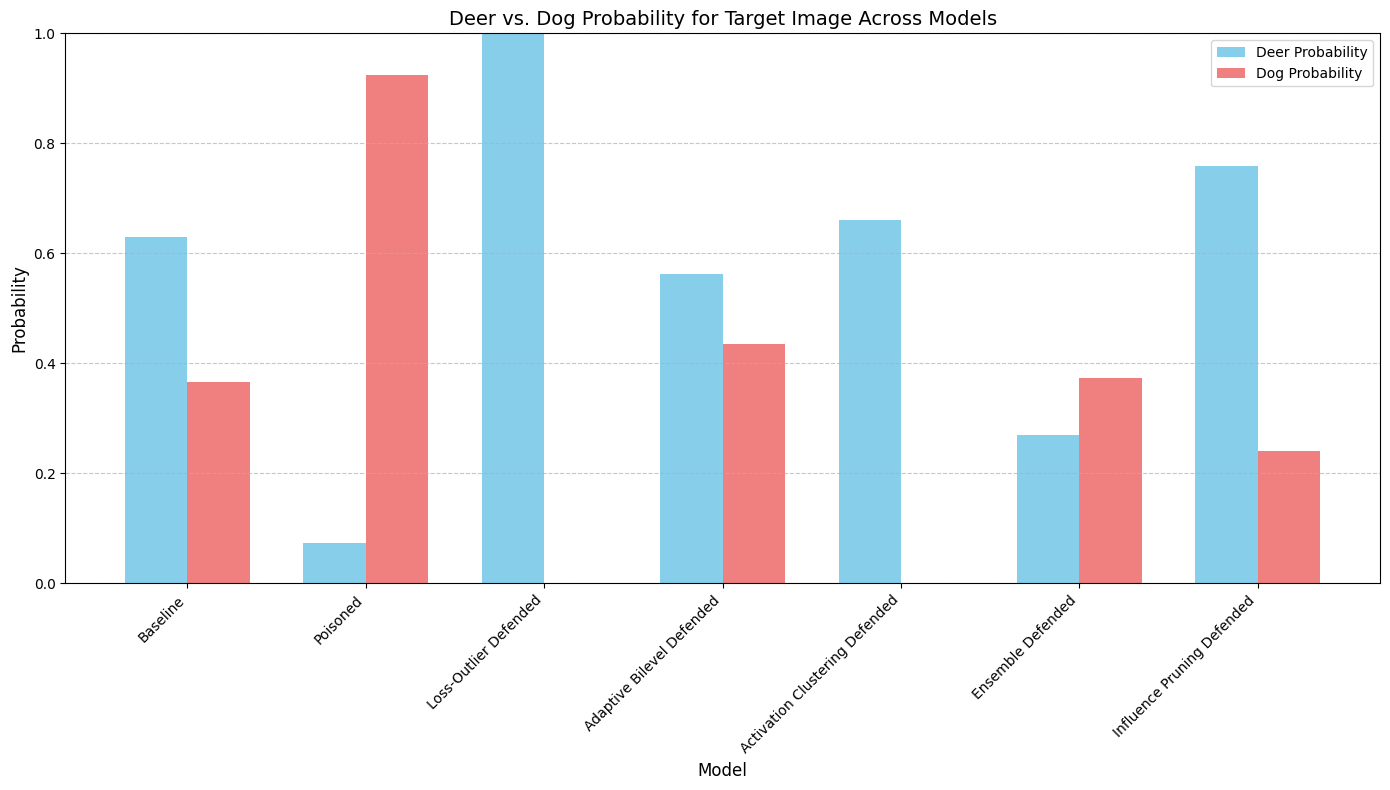

Bar chart visualizing deer and dog probabilities across models displayed.


In [50]:
import matplotlib.pyplot as plt
import numpy as np

# set up the figure size for better readability
plt.figure(figsize=(14, 8))

# define the bar width and positions
bar_width = 0.35
index = np.arange(len(prob_df['Model']))

# create the bars for 'Deer Probability'
plt.bar(index, prob_df['Deer Probability'], bar_width, label='Deer Probability', color='skyblue')

# create the bars for 'Dog Probability', slightly offset
plt.bar(index + bar_width, prob_df['Dog Probability'], bar_width, label='Dog Probability', color='lightcoral')

# add labels, title, and ticks
plt.xlabel('Model', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.title('Deer vs. Dog Probability for Target Image Across Models', fontsize=14)
plt.xticks(index + bar_width / 2, prob_df['Model'], rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 1) # probabilities are between 0 and 1
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() # adjust layout to prevent labels from overlapping

# display the plot
plt.show()

print("Bar chart visualizing deer and dog probabilities across models displayed.")

In [53]:
import pandas as pd

# create a list named of model names
model_names = [
    'Baseline',
    'Poisoned',
    'Loss-Outlier Defended',
    'Adaptive Bilevel Defended',
    'Activation Clustering Defended',
    'Ensemble Defended',
    'Influence Pruning Defended'
]

# create a list named of test accuracies
test_accuracies = [
    test_acc,
    test_acc_poisoned,
    test_acc_defended,
    test_acc_bilevel_defended_adaptive,
    test_acc_defended_activation_clustering,
    test_acc_ensemble,
    test_acc_defended_influence
]

# create a Pandas DataFrame
accuracy_df = pd.DataFrame({
    'Model': model_names,
    'Test Accuracy': test_accuracies
})

# print the DataFrame
print(accuracy_df)

                            Model  Test Accuracy
0                        Baseline         0.9326
1                        Poisoned         0.9203
2           Loss-Outlier Defended         0.9168
3       Adaptive Bilevel Defended         0.9087
4  Activation Clustering Defended         0.8449
5               Ensemble Defended         0.9302
6      Influence Pruning Defended         0.9257


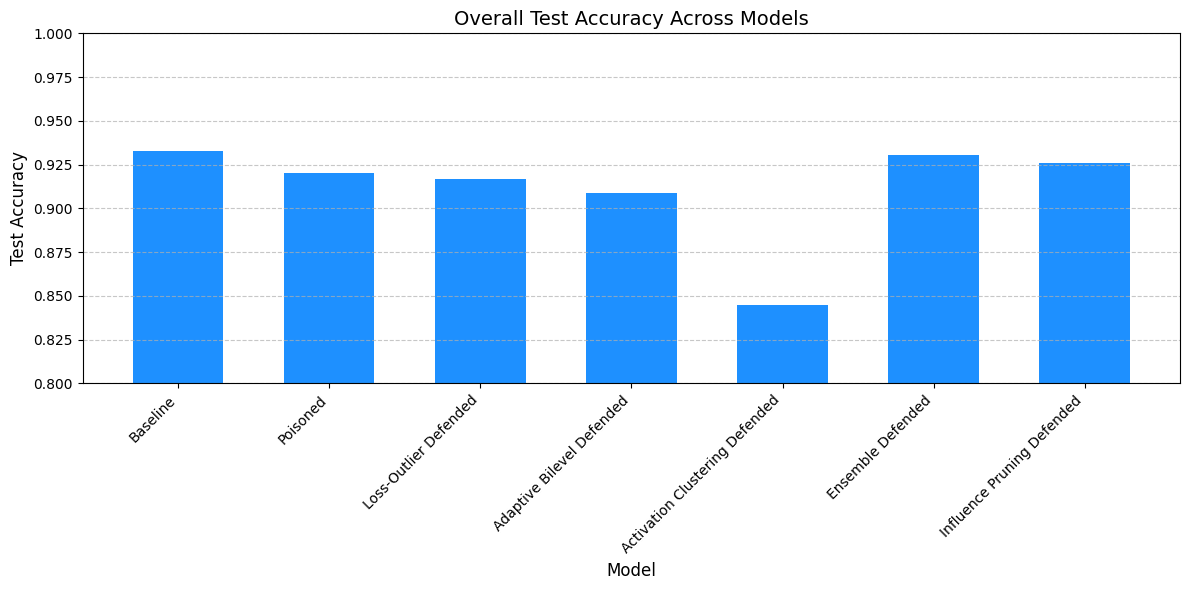

Bar chart visualizing overall test accuracies across models displayed.


In [54]:
import matplotlib.pyplot as plt
import numpy as np

# set up the figure size for better readability
plt.figure(figsize=(12, 6))

# define the bar width and positions
bar_width = 0.6
index = np.arange(len(accuracy_df['Model']))

# create the bars for 'Test Accuracy'
plt.bar(index, accuracy_df['Test Accuracy'], bar_width, color='dodgerblue')

# add labels, title, and ticks
plt.xlabel('Model', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Overall Test Accuracy Across Models', fontsize=14)
plt.xticks(index, accuracy_df['Model'], rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0.8, 1) # accuracy is between 0.8 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout() # adjust layout to prevent labels from overlapping

# display the plot
plt.show()

print("Bar chart visualizing overall test accuracies across models displayed.")